# Conditional Generative Adversarial Network

Conditional Generative Adversarial Nets - [Paper](https://arxiv.org/pdf/1411.1784.pdf)

Adversarial nets advantages
* Markov chains not needed
* Only backpropagation used to obtain gradients
* No inference required during learning
* Wide variety of factors and interactions can be easily incorporated into the model.
* Produce SOTA log-likelihood estimates and realistic samples

Conditional model
* Condition the model on additional information, y, to direct the data generation process


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

import tensorflow as tf

def plot_data(X, y):
    """Plot 2D or 3D according to X dimension."""
    if X.shape[1] == 1:
        for i in range(y.shape[1]):
            plt.plot(X, y[:,i], '.')
            plt.show()
    if X.shape[1] == 2:
        for i in range(y.shape[1]):
            ax = plt.axes(projection='3d')
            ax.scatter(X[:,0], X[:,1], y[:,i], c=y[:,i], cmap='viridis')
            plt.show()
            
def get_normal_data(n=1000, plot=False, xy_features=(2,1)):
    """Get normal dataset of x=(n*4,2), y=(n*4,1)."""
    x0 = np.concatenate([
        np.random.normal(10, 2, size=n),
        np.random.normal(10, 2, size=n),
        np.random.normal(20, 2, size=n),
        np.random.normal(20, 2, size=n),
    ])
    x1 = np.concatenate([
        np.random.normal(30, 2, size=n),
        np.random.normal(40, 2, size=n),
        np.random.normal(30, 2, size=n),
        np.random.normal(40, 2, size=n),
    ])
    y = np.concatenate([
        np.random.normal(50, 2, size=n),
        np.random.normal(60, 2, size=n),
        np.random.normal(70, 2, size=n),
        np.random.normal(80, 2, size=n),
    ])
    data = np.stack((x0, x1, y), axis=1).astype(np.float32)
    np.random.shuffle(data)
    
    if plot:
        ax = plt.axes(projection='3d')
        ax.scatter(data[:,0], data[:,1], data[:,2], alpha=0.3, c='r')
        plt.show()
    
    return (data[:,:2], np.expand_dims(data[:,2], axis=1)) \
            if xy_features == (2,1) else \
            (np.expand_dims(data[:,0], axis=1), data[:,1:])

X, y shapes: (4000, 2) (4000, 1)


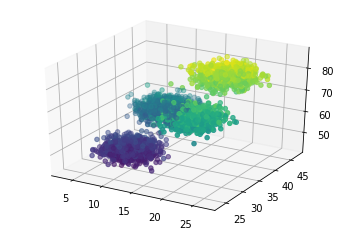

In [5]:
# Use normal dataset
n = 1000
X, y = get_normal_data(n, xy_features=(2,1))
print("X, y shapes:", X.shape, y.shape)

# Plot 2D or 3D graph according to X dimension
plot_data(X, y)

# Convert to TF dataset
n = len(X)
dataset = tf.data.Dataset \
    .from_tensor_slices((X,y)) \
    .shuffle(n).batch(32)

epoch  0 complete
loss: tf.Tensor(2.235053, shape=(), dtype=float32) d_loss:  tf.Tensor(0.18026316, shape=(), dtype=float32)
condition  Dress


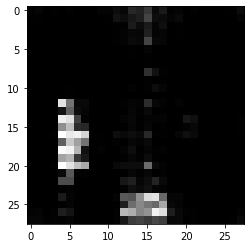

epoch  1 complete
loss: tf.Tensor(3.2142012, shape=(), dtype=float32) d_loss:  tf.Tensor(0.067635596, shape=(), dtype=float32)
condition  Dress


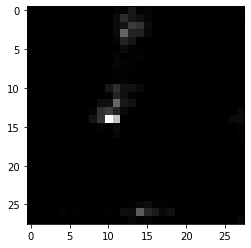

epoch  2 complete
loss: tf.Tensor(2.3019369, shape=(), dtype=float32) d_loss:  tf.Tensor(0.44461805, shape=(), dtype=float32)
condition  Dress


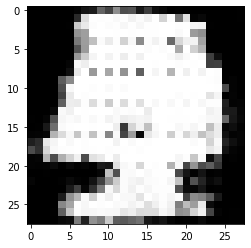

KeyboardInterrupt: 

In [4]:
import tensorflow as tf


def get_generator(latent_dimension):
    # Condition subnetwork: encode the condition in a hidden representation
    condition = tf.keras.layers.Input((1,))
    net = tf.keras.layers.Dense(32, activation=tf.nn.elu)(condition)
    net = tf.keras.layers.Dense(64, activation=tf.nn.elu)(net)

    # Concatenate the hidden condition representation to noise and upsample
    noise = tf.keras.layers.Input(latent_dimension)
    inputs = tf.keras.layers.Concatenate()([noise, net])

    # Convert inputs from (batch_size, latent_dimension + 1)
    # To a 4-D tensor, that can be used with convolutions
    inputs = tf.keras.layers.Reshape((1, 1, inputs.shape[-1]))(inputs)

    depth = 128
    kernel_size = 5
    net = tf.keras.layers.Conv2DTranspose(depth, kernel_size, padding="valid", strides=1, activation=tf.nn.relu)(inputs)  # 5x5
    net = tf.keras.layers.Conv2DTranspose(depth // 2, kernel_size, padding="valid", strides=2, activation=tf.nn.relu)(net)  # 13x13
    net = tf.keras.layers.Conv2DTranspose(depth // 4, kernel_size, padding="valid", strides=2, activation=tf.nn.relu, use_bias=False)(net)  # 29x29
    
    # Standard convolution with a 2x2 kernel to obtain a 28x28x1 out
    # The output is a sigmoid, since the images are in the [0,1] range
    net = tf.keras.layers.Conv2D(1, 2, padding="valid", strides=1, activation=tf.nn.sigmoid, use_bias=False)(net)
    model = tf.keras.Model(inputs=[noise, condition], outputs=net)
    return model


latent_dimension = 100
G = get_generator(latent_dimension)


def get_discriminator():
    # Encoder subnetwork: feature extactor to get a feature vector
    image = tf.keras.layers.Input((28, 28, 1))
    depth = 32
    kernel_size = 3
    net = tf.keras.layers.Conv2D(depth, kernel_size, padding="same", strides=2, activation=tf.nn.relu)(image)  # 14x14x32
    net = tf.keras.layers.Conv2D(depth * 2, kernel_size, padding="same", strides=2, activation=tf.nn.relu)(net)  # 7x7x64
    net = tf.keras.layers.Conv2D(depth * 3, kernel_size, padding="same", strides=2, activation=tf.nn.relu)(net)  # 4x4x96

    feature_vector = tf.keras.layers.Flatten()(net)  # 4*4*96

    # Create a hidden representation of the condition
    condition = tf.keras.layers.Input((1,))
    hidden = tf.keras.layers.Dense(32, activation=tf.nn.elu)(condition)
    hidden = tf.keras.layers.Dense(64, activation=tf.nn.elu)(hidden)

    # Concatenate the feature vector and the hidden label representatio
    out = tf.keras.layers.Concatenate()([feature_vector, hidden])

    # Add the final classification layers with a single linear neuron
    out = tf.keras.layers.Dense(128, activation=tf.nn.relu)(out)
    out = tf.keras.layers.Dense(1)(out)

    model = tf.keras.Model(inputs=[image, condition], outputs=out)
    return model


D = get_discriminator()

bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def d_loss(d_real, d_fake):
    """The disciminator loss function."""
    return bce(tf.ones_like(d_real), d_real) + bce(tf.zeros_like(d_fake), d_fake)


def g_loss(generated_output):
    """The Generator loss function."""
    return bce(tf.ones_like(generated_output), generated_output)


# Commented out IPython magic to ensure Python compatibility.
import matplotlib.pyplot as plt

# %matplotlib inline


def train():
    # Define the optimizers and the train operations
    optimizer = tf.keras.optimizers.Adam(1e-5)

    @tf.function
    def train_step(image, label):
        with tf.GradientTape(persistent=True) as tape:
            noise_vector = tf.random.normal(
                mean=0, stddev=1, shape=(image.shape[0], latent_dimension)
            )
            # Sample from the Generator
            fake_data = G([noise_vector, label])
            # Compute the D loss
            d_fake_data = D([fake_data, label])
            d_real_data = D([image, label])

            d_loss_value = d_loss(d_real_data, d_fake_data)
            # Compute the G loss
            g_loss_value = g_loss(d_fake_data)
        # Now that we comptuted the losses we can compute the gradient (using the tape)
        # and optimize the networks
        d_gradients = tape.gradient(d_loss_value, D.trainable_variables)
        g_gradients = tape.gradient(g_loss_value, G.trainable_variables)
        # Deletng the tape, since we defined it as persistent (because we used it twice)
        del tape

        optimizer.apply_gradients(zip(d_gradients, D.trainable_variables))
        optimizer.apply_gradients(zip(g_gradients, G.trainable_variables))
        return g_loss_value, d_loss_value, fake_data[0], label[0]

    epochs = 50
    for epoch in range(epochs):
        for image, label in dataset:
            g_loss_value, d_loss_value, generated, condition = train_step(image, label)

        print("epoch ", epoch, "complete")
        print("loss:", g_loss_value, "d_loss: ", d_loss_value)
        print(
            "condition ",
            info.features["label"].int2str(
                tf.squeeze(tf.cast(condition, tf.int32)).numpy()
            ),
        )
        plt.imshow(tf.squeeze(generated).numpy(), cmap="gray")
        plt.show()


train()

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

class CGAN:
    def __init__(self, x_features, y_features, latent_dim):
        self.x_features = x_features
        self.y_features = y_features
        self.latent_dim = latent_dim
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        self.gan = self.build_gan()
        self.optimizer = Adam()
        self.generator.summary()
        
    def build_generator(self):
        noise = Input(shape=(self.latent_dim,))
        d_noise = Dense(16, activation='relu')(noise)
        x = Input(shape=(self.x_features,))
        d_x = Dense(16, activation='relu')(x)
        z = Concatenate()([d_noise, d_x])
        d_z = Dense(16, activation='relu')(z)
        y = Dense(self.y_features)(d_z)
        return Model([noise, x], y)
    
    def build_discriminator(self):
        x = Input(shape=(self.x_features))
        d_x = Dense(16)(x)
        y = Input(shape=(self.y_features))
        d_y = Dense(16)(y)
        h = Concatenate()([d_x, d_y])
        h = Dense(16)(h)
        h = Dropout(0.4)(h)
        p = Dense(1, activation='sigmoid')(h)
        model = Model([y, x], p)
        return model
    
    def build_gan(self):
        self.discriminator.trainable = False
        noise, x = self.generator.input
        y = self.generator.output
        p = self.discriminator([y, x])
        model = Model([noise, x], p)
        return model
    
    @tf.function
    def train_discriminator(self, X, y, noise):
        y_pred = self.generator.predict((noise, X))
        with tf.GradientTape() as t:
            loss_real = self.discriminator.train_on_batch((y, X), real)
            loss_fake = self.discriminator.train_on_batch((y_pred, X), fake)
            loss = 0.5 * tf.add(loss_real, loss_fake)
        gradients = t.gradient(loss, self.gan.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        
    @tf.function
    def train_generator(self, noise, real):
        return self.gan.train_on_batch(noise, real)
    
    def fit(self, dataset, epochs=1000):
        real = np.ones((32, 1))
        fake = np.ones((32, 1))
        for i in range(epochs):
            for X_train, y_train in dataset:
                noise = np.random.normal(0, 1, (32, self.latent_dim))
                print(X_train.shape, y_train.shape, noise.shape)
                d_loss = self.train_discriminator(X_train, y_train, noise)
                g_loss = self.train_generator(noise, real)
            print(f"{epoch} [D loss: {d_loss}] [G loss: {g_loss}]")

In [13]:
cgan = CGAN(2,1,16)

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 16)]         0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense_24 (Dense)                (None, 16)           272         input_13[0][0]                   
__________________________________________________________________________________________________
dense_25 (Dense)                (None, 16)           48          input_14[0][0]                   
____________________________________________________________________________________________

In [14]:
cgan.fit(dataset)

(32, 2) (32, 1) (32, 16)


AttributeError: in user code:

    <ipython-input-12-cc5a1c594d91>:50 train_discriminator  *
        y_pred = self.generator.predict((noise, X))
    C:\Users\notes\Anaconda3\envs\grab\lib\site-packages\tensorflow\python\keras\engine\training.py:88 _method_wrapper  **
        return method(self, *args, **kwargs)
    C:\Users\notes\Anaconda3\envs\grab\lib\site-packages\tensorflow\python\keras\engine\training.py:1286 predict
        return tf_utils.to_numpy_or_python_type(all_outputs)
    C:\Users\notes\Anaconda3\envs\grab\lib\site-packages\tensorflow\python\keras\utils\tf_utils.py:523 to_numpy_or_python_type
        return nest.map_structure(_to_single_numpy_or_python_type, tensors)
    C:\Users\notes\Anaconda3\envs\grab\lib\site-packages\tensorflow\python\util\nest.py:617 map_structure
        structure[0], [func(*x) for x in entries],
    C:\Users\notes\Anaconda3\envs\grab\lib\site-packages\tensorflow\python\util\nest.py:617 <listcomp>
        structure[0], [func(*x) for x in entries],
    C:\Users\notes\Anaconda3\envs\grab\lib\site-packages\tensorflow\python\keras\utils\tf_utils.py:519 _to_single_numpy_or_python_type
        x = t.numpy()

    AttributeError: 'Tensor' object has no attribute 'numpy'


# Probabilistic Graphical Model

Probabilistic Graphical Model is a probabilistic model for which a graph expresses the conditional dependence structure between random variables. Directed Graphical Models (DGMs) (or Bayesian Networks BNs) represent conditional dependencies between variables.

Structure learning methods of the PGM can be either constraint- or score-based.

Constraint-based structure learning use statistics tests to learn marginal/conditional independence relationships (or constraints) from the data and prune the graph-searching space using obtained constraints.

Score-based structure learning assigns each candidate Directed Acyclic Graph (DAG) a score reflecting the goodness of fit as the objective function to be optimised, and uses a global score such as BIC or Bayesian marginal likelihood to find structures that maximises the score.